In [1]:
import pandas as pd
import cluj_tools as ct

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database

from secrets import *

### Get Rosters

In [2]:
matchup_end_date, matchupPeriod = ct.matchup_end_date()

Matchup end date is 2020-02-23
Matchup period is 17


In [3]:
rosters = ct.get_rosters(matchupPeriod)

### Get Boxscore data to calculate octys

In [4]:
dbname = 'cluj'
engine = create_engine('postgres://%s:%s@localhost/%s'%(AUTH['db_user'],AUTH['db_pass'],dbname))

if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

True


In [5]:
sql = """
    SELECT * FROM boxscores b
    LEFT JOIN player_name_comparison c ON b.name = c.boxscore_name
    WHERE b.season_year = '2019-2020' AND b.season_type = 'regular'
"""

In [6]:
boxscores = pd.read_sql(sql, engine)
boxscores['ft_pct'] = boxscores.ftm / boxscores.fta
boxscores['fg_pct'] = boxscores.fgm / boxscores.fga

In [7]:
boxscores.loc[boxscores.espn_name.isnull(),'espn_name'] = boxscores.loc[boxscores.espn_name.isnull(),'name']

In [8]:
ft_pct_threshold = 0.75
fg_pct_threshold = 0.4
octys = boxscores.loc[(boxscores.assists > 0) & (boxscores.threes > 0) & (boxscores.steals > 0) & (boxscores.rebounds > 0) & (boxscores['blocks'] > 0) & (boxscores.ft_pct > ft_pct_threshold) & (boxscores.fg_pct > fg_pct_threshold)]
octys.shape

(443, 21)

In [9]:
octy_counts = pd.DataFrame(octys.espn_name.value_counts())
octy_counts.reset_index(inplace=True)
octy_counts.rename(columns={'espn_name':'octy_count', 'index':'espn_name'}, inplace=True)

In [10]:
octy_counts.head()

,espn_name,octy_count
0,Anthony Davis,14
1,James Harden,12
2,Kawhi Leonard,10
3,Joel Embiid,10
4,Brandon Ingram,8


In [11]:
octys_games = pd.DataFrame(boxscores.groupby('espn_name')['assists'].count())
octys_games.reset_index(inplace=True)
octys_games.rename(columns={'assists':'game_count'}, inplace=True)

In [12]:
merged = octy_counts.merge(octys_games, on='espn_name')
merged['octy_pct'] = merged.octy_count / merged.game_count
merged.sort_values('octy_pct', ascending=False, inplace=True)
merged.shape

(182, 4)

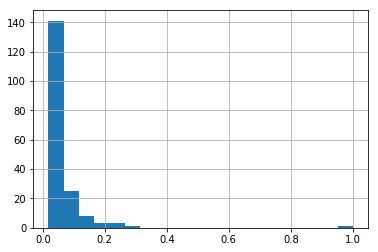

In [13]:
merged.octy_pct.hist(bins=20)

In [14]:
merged.head(30)

,espn_name,octy_count,game_count,octy_pct
115,P.J. Washington,1,1,1.000000
0,Anthony Davis,14,46,0.304348
3,Joel Embiid,10,40,0.250000
2,Kawhi Leonard,10,42,0.238095
1,James Harden,12,52,0.230769
23,Kyrie Irving,4,20,0.200000
10,John Collins,6,31,0.193548
4,Brandon Ingram,8,47,0.170213
7,Pascal Siakam,7,44,0.159091
5,Nikola Jokic,8,55,0.145455


In [15]:
rosters_merge = merged.merge(rosters, left_on='espn_name', right_on='fullName', how='left')
rosters_merge.shape

(182, 6)

In [16]:
rosters_merge.groupby('teamId')['octy_pct'].mean().sort_values()

teamId
1.0     0.050558
2.0     0.051791
9.0     0.051908
11.0    0.055730
12.0    0.057623
3.0     0.059630
8.0     0.061872
10.0    0.064013
6.0     0.066201
5.0     0.075000
7.0     0.079691
4.0     0.097038
Name: octy_pct, dtype: float64

In [17]:
rosters_merge.groupby('teamId')['octy_count'].sum().sort_values()

teamId
2.0     18
1.0     22
11.0    22
12.0    24
8.0     25
9.0     26
6.0     28
3.0     29
7.0     34
5.0     38
10.0    38
4.0     52
Name: octy_count, dtype: int64

In [18]:
rosters_merge.loc[rosters_merge.teamId == 10]

,espn_name,octy_count,game_count,octy_pct,fullName,teamId
9,Nikola Jokic,8,55,0.145455,Nikola Jokic,10.0
10,Josh Richardson,6,42,0.142857,Josh Richardson,10.0
18,Myles Turner,5,45,0.111111,Myles Turner,10.0
28,Mikal Bridges,5,55,0.090909,Mikal Bridges,10.0
37,Miles Bridges,4,55,0.072727,Miles Bridges,10.0
79,Derrick Rose,2,46,0.043478,Derrick Rose,10.0
89,Giannis Antetokounmpo,2,49,0.040816,Giannis Antetokounmpo,10.0
111,Justin Holiday,2,55,0.036364,Justin Holiday,10.0
124,Elfrid Payton,1,36,0.027778,Elfrid Payton,10.0
164,Seth Curry,1,51,0.019608,Seth Curry,10.0


In [19]:
# should only be players on waiver wire
rosters_merge.loc[rosters_merge.fullName.isnull()].sort_values('octy_pct', ascending=False).head(20)

,espn_name,octy_count,game_count,octy_pct,fullName,teamId
0,P.J. Washington,1,1,1.000000,NaN,NaN
14,Josh Jackson,1,8,0.125000,NaN,NaN
20,Kadeem Allen,1,10,0.100000,NaN,NaN
24,Jonathan Isaac,3,32,0.093750,NaN,NaN
26,Justise Winslow,1,11,0.090909,NaN,NaN
33,Lauri Markkanen,4,46,0.086957,NaN,NaN
41,PJ Dozier,1,15,0.066667,NaN,NaN
49,Jabari Parker,2,33,0.060606,NaN,NaN
52,Josh Okogie,3,51,0.058824,NaN,NaN
63,Maxi Kleber,3,54,0.055556,NaN,NaN
